Based on this work: https://gist.github.com/mmmikael/0a3d4fae965bdbec1f9d

In [1]:
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
# from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout
# from keras.initializers import glorot_uniform
# from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.models import Sequential
from keras.models import Model
# from keras.applications import ResNet50,VGG16
import numpy as np

Using TensorFlow backend.


In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [0]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
def siamese_network(input_shape):
    left_input = Input((input_shape[0],input_shape[1],1))
    right_input = Input((input_shape[0],input_shape[1],1))
    model=Sequential()
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    encoded_l = model(left_input)
    encoded_r = model(right_input) 
    L1_distance = Lambda(euclidean_distance)([encoded_l, encoded_r])
    return Model(inputs=[left_input,right_input],outputs=L1_distance)



In [5]:
input_shape=(28,28)
model = siamese_network(input_shape)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 512)          1328640     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]               
          

In [6]:
from keras.datasets import fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))
X_test.shape

4423680/4422102 [==============================] - 2s 0us/step


(10000, 28, 28, 1)

In [7]:
import numpy as np
digit_indices = [np.where(Y_train == i)[0] for i in range(10)]
digit_indices[2].shape

(6000,)

In [0]:
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    print(n)
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [9]:
import random
digit_indices = [np.where(Y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(Y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)
tr_pairs.shape

5999
999


(119980, 2, 28, 28, 1)

In [0]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [0]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [13]:
from keras.callbacks import LearningRateScheduler
optimizer = RMSprop()
model.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[accuracy])
hist=model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=128, nb_epoch=20,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 119980 samples, validate on 19980 samples
Epoch 1/20
119980/119980 [==============================] - 9s 77us/step - loss: 0.1329 - accuracy: 0.8354 - val_loss: 0.0991 - val_accuracy: 0.8740
Epoch 2/20
119980/119980 [==============================] - 7s 60us/step - loss: 0.0875 - accuracy: 0.8883 - val_loss: 0.0841 - val_accuracy: 0.8927
Epoch 3/20
119980/119980 [==============================] - 7s 59us/step - loss: 0.0787 - accuracy: 0.9005 - val_loss: 0.0870 - val_accuracy: 0.8867
Epoch 4/20
119980/119980 [==============================] - 7s 59us/step - loss: 0.0735 - accuracy: 0.9083 - val_loss: 0.0837 - val_accuracy: 0.8972
Epoch 5/20
119980/119980 [==============================] - 7s 59us/step - loss: 0.0701 - accuracy: 0.9132 - val_loss: 0.0778 - val_accuracy: 0.9024
Epoch 6/20
119980/119980 [==============================] - 7s 59us/step - loss: 0.0668 - accuracy: 0.9179 - val_loss: 0.0757 - val_accuracy: 0.9069
Epoch 7/20
119980/119980 [=============================

In [0]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

In [15]:
pred_y=model.predict([te_pairs[:, 0], te_pairs[:, 1]])
compute_accuracy(tr_y, pred_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """


0.0

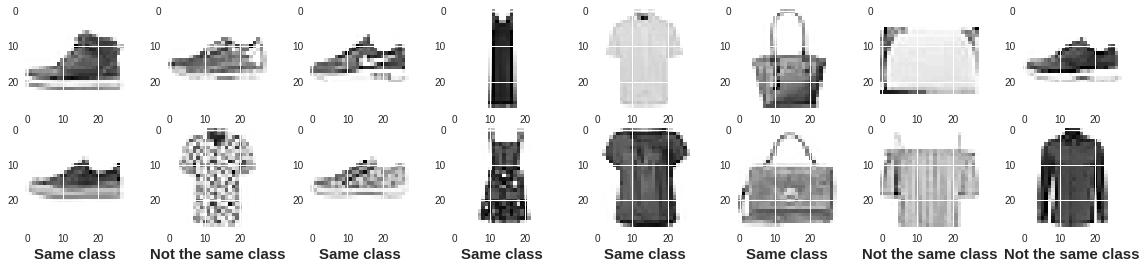

In [17]:
import matplotlib.pyplot as plt
import cv2

pics_number=8
pr_list=np.random.randint(0, te_pairs.shape[0], size=pics_number)

fig=plt.figure(figsize=(20, 4))
# fig, axes = plt.subplots(nrows=2, ncols=pics_number,figsize=(20, 10))
fig.tight_layout()

print_i=0
for row in pr_list:
  print_i+=1
  img1=te_pairs[row,0]
  img2=te_pairs[row,1]
  img1=img1.reshape(28,28)
  img2=img2.reshape(28,28)

  fig.add_subplot(2, pics_number, print_i)
  plt.imshow(img1)
  fig.add_subplot(2, pics_number, print_i+pics_number)
  plt.imshow(img2)
  if pred_y[row]>0.5:
    text='Not the same class'
  else:
    text='Same class'
  plt.xlabel('{}'.format(text),fontsize = 15,fontweight="bold")
#   fig.tight_layout()
